# Improve Cache Efficiency by Blocking
:label:`ch_block_matmul_cpu`

In :numref:`ch_matmul_cpu` we saw that properly reordering the loop axes to get more friendly memory access pattern, together with thread-level parallelization, could dramatically improve the performance for matrix multiplication. 
The results show that for small-scale matrices, our performance outperforms the NumPy baseline.
However, for large matrices, we need to carefully consider the cache hierarchy discussed in :numref:`ch_cpu_arch`.


In [1]:
%matplotlib inline
import tvm
from tvm import te
import numpy as np
import d2ltvm

# target = 'llvm -mcpu=skylake-avx512'
target = 'llvm'

Before we started, let's rerun the benchmark for NumPy as our baseline.


In [2]:
sizes = 2**np.arange(5, 12, 1)
exe_times = [d2ltvm.bench_workload(d2ltvm.np_matmul_timer(n)) for n in sizes]
np_gflops = 2 * sizes **3 / 1e9 / np.array(exe_times)

## Blocked Matrix Multiplication

One commonly used strategy is tiling matrices into small blocks that can be fitted into the cache.
The math behind it is that a block of $C$, e.g. `C[x:x+tx, y:y+ty]` by the NumPy notation, can be computed by the corresponding rows of $A$ and columns of $B$. That is

``C[x:x+tx, y:y+ty] = np.dot(A[x:x+tx,:], B[:,y:y+ty])``

We can further decompose this matrix multiplication into multiple small ones

``C[x:x+tx, y:y+ty] = sum(np.dot(A[x:x+tx,k:k+tk], B[k:k+tk,y:y+ty]) for k in range(0,n,tk))``

This computation is also illustrated in :numref:`fig_matmul_block`.

![Blocked tiling for matrix multiplication.](../img/matmul_block.svg)
:label:`fig_matmul_block`

In each submatrix computation, we need to write a `[tx, ty]` shape matrix, and reach two matrices with shapes `[tx, tk]` and `[tk, ty]`. We can compute such a computation in a single CPU core. If we properly choose the tiling sizes `tx`, `ty` and `tk` to fit into the L1 cache, which is 32KB for our CPU (refer to :numref:`ch_cpu_arch`). The reduced cache miss then should improve the performance.

Let's implement this idea. In the following code block, we choose `tx=ty=32` and `tk=4` so that the submatrix to write has a size of `32*32*4=4KB` and the total size of the two submatrices to read is `2*32*4*4=1KB`. The three matrices together can fit into our L1 cache easily. The tiling is implemented by the `tile` primitive.

After tiling, we merge the outer width and height axes into a single one using the `fuse` primitive, so we can parallelize it. It means that we will compute blocks in parallel. Within a block, we split the reduced axis, reorder the axes as we did in:numref:`ch_matmul_cpu`, and then vectorize the innermost axis using SIMD instructions, and unroll the second innermost axis using the `unroll` primitive, namely the inner reduction axis.


In [3]:
tx, ty, tk = 32, 32, 4  # tile sizes

def block(n):
    A, B, C = d2ltvm.matmul(n, n, n)
    s = te.create_schedule(C.op)
    # Tile by blocks, and then parallelize the computation of each block
    xo, yo, xi, yi = s[C].tile(*C.op.axis, tx, ty)
    xy = s[C].fuse(xo, yo)
    s[C].parallel(xy)
    # Optimize the computation of each block
    ko, ki = s[C].split(s[C].op.reduce_axis[0], factor=tk)
    s[C].reorder(ko, xi, ki, yi)
    s[C].vectorize(yi)
    s[C].unroll(ki)
    return s, (A, B, C)

s, (A, B, C) = block(64)
print(tvm.lower(s, [A, B, C], simple_mode=True))

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer((64, 64), "float32"), B: T.Buffer((64, 64), "float32"), T_matmul: T.Buffer((64, 64), "float32")):
        T.func_attr({"from_legacy_te_schedule": T.bool(True), "tir.noalias": T.bool(True)})
        for ax0_outer_ax1_outer_fused in T.parallel(4):
            T_matmul_1 = T.Buffer((4096,), data=T_matmul.data)
            for ax0_inner_init in range(32):
                T_matmul_1[ax0_outer_ax1_outer_fused // 2 * 2048 + ax0_inner_init * 64 + ax0_outer_ax1_outer_fused % 2 * 32:ax0_outer_ax1_outer_fused // 2 * 2048 + ax0_inner_init * 64 + ax0_outer_ax1_outer_fused % 2 * 32 + 32] = T.Broadcast(T.float32(0.0), 32)
            for k_outer, ax0_inner in T.grid(16, 32):
                cse_var_5: T.int32 = ax0_outer_ax1_outer_fused % 2 * 32
                cse_var_4: T.int32 = ax0_outer_ax1_outer_fused // 2 * 2048 + ax0_inner * 64
                cse_var_3: T.i

From the generated C-like codes, we can see that `parallel` is placed on the `x.outer`, i.e. `xo`, axis. The vectorization translated the axis `yi`, whose length is 32, into `ramp` with a stride 1 and width 32. Besides, the axis `ki` is also unrolled into 4 sequential operations to reduce the cost of the for-loop.


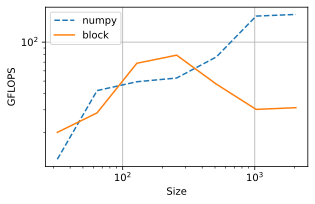

In [4]:
blocked_gflops = d2ltvm.bench_matmul_tvm(block, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, blocked_gflops], ['numpy', 'block'])

The benchmark results show that our program is as good as NumPy for small matrices, but still doesn't do well for large ones. One major reason is because both read and write of these submatrices are not continuous after tiling.

## Write Cache

The non-continuous write issue is severer than the non-continuous read. This is because we read once of each submatrix of `A` and `B`, but need to write by `n` times for the submatrix of `C`. In the following code block, we first write the results into a local buffer for each submatrix computation, and then write them back to `C`. It can be done by the `cache_write` method. We specify the buffer being used for each block by placing it within the `yo` axis using the `compute_at` primitive. The rest optimization is the same as before, but note that we need to use `s[Cached]` instead of `s[C]` to optimize the submatrix computation.


In [5]:
def cached_block(n):
    A, B, C = d2ltvm.matmul(n, n, n)
    s = te.create_schedule(C.op)
    # Create a write cache for C
    CachedC = s.cache_write(C, 'local')
    # Same as before, first tile by blocks, and then parallelize the
    # computation of each block
    xo, yo, xi, yi = s[C].tile(*C.op.axis, tx, ty)
    xy = s[C].fuse(xo, yo)
    s[C].parallel(xy)
    # Use the write cache for the output of the xy axis, namely a block.
    s[CachedC].compute_at(s[C], xy)
    # Same as before to optimize the computation of a block .
    xc, yc = s[CachedC].op.axis
    ko, ki = s[CachedC].split(CachedC.op.reduce_axis[0], factor=tk)
    s[CachedC].reorder(ko, xc, ki, yc)
    s[CachedC].unroll(ki)
    s[CachedC].vectorize(yc)
    return s, (A, B, C)

s, (A, B, C) = cached_block(512)
print(tvm.lower(s, [A, B, C], simple_mode=True))

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer((512, 512), "float32"), B: T.Buffer((512, 512), "float32"), T_matmul: T.Buffer((512, 512), "float32")):
        T.func_attr({"from_legacy_te_schedule": T.bool(True), "tir.noalias": T.bool(True)})
        for ax0_outer_ax1_outer_fused in T.parallel(256):
            T_matmul_local = T.allocate([1024], "float32", "local")
            T_matmul_local_1 = T.Buffer((1024,), data=T_matmul_local, scope="local")
            for ax0_c_init in range(32):
                T_matmul_local_1[ax0_c_init * 32:ax0_c_init * 32 + 32] = T.Broadcast(T.float32(0.0), 32)
            for k_outer, ax0_c in T.grid(128, 32):
                cse_var_3: T.int32 = ax0_c * 32
                cse_var_2: T.int32 = k_outer * 2048 + ax0_outer_ax1_outer_fused % 16 * 32
                cse_var_1: T.int32 = ax0_outer_ax1_outer_fused // 16 * 16384 + ax0_c * 512 + k_outer * 4
                

Note from the generated pseudo codes that we initialize `C.local` within the `yo` axis, and the size of `C.local` is `tx * ty = 1024`.


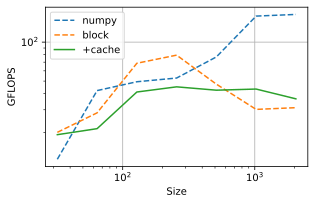

In [6]:
cached_gflops = d2ltvm.bench_matmul_tvm(cached_block, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, blocked_gflops, cached_gflops],
            ['numpy', 'block', '+cache'])

We can see the the write cache improves the performance for matrix multiplication on large sizes.

## Summary

- Blocked tiling improves cache efficiency for matrix multiplication.
- Data to be frequently read and written should be placed in a buffer explicitly to reduce cache misses.

## Exercises

1. Try different hyperparameters for `tx`, `ty` and `tx`.
1. Try different axis orders.
1. Benchmark on larger matrices, observe if there is still performance gap between NumPy. If so, try to explain the reason.
1. Evaluate the correctness of the computed results.
